## Post-process a finetuned LLM

Test and upload a finetuned language model

## Setup

In [1]:
import transformers
import torch
import tensorflow as tf

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
!nvidia-smi

Sun Jul  2 16:20:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA H100 PCIe    On   | 00000000:06:00.0 Off |                    0 |
| N/A   37C    P0    48W / 350W |      3MiB / 81559MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
free_in_GB = int(torch.cuda.mem_get_info()[0] / 1024**3)
max_memory = f"{free_in_GB-2}GB"
n_gpus = torch.cuda.device_count()
max_memory = {i: max_memory for i in range(n_gpus)}
print("max memory: ", max_memory)

max memory:  {0: '76GB'}


## Loss curve

In [4]:
# assumes you have already run `sft-instruction-llm.py`
# see documentation and comments therein for details
# recommendation: run `sft-instruction-llm.py` directly from the terminal
# by default, the mpt-7b instruction model demo is used


# load the train loss from the finetuning events log
train_steps = []
train_loss = []
path_to_events_file = "./results/runs/Jul02_13-43-49_209-20-157-73/events.out.tfevents.1688305438.209-20-157-73.73470.0"
for e in tf.compat.v1.train.summary_iterator(path_to_events_file):
    for v in e.summary.value:
        if "loss" in v.tag:
            train_loss.append(v.simple_value)
            train_steps.append(e.step)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


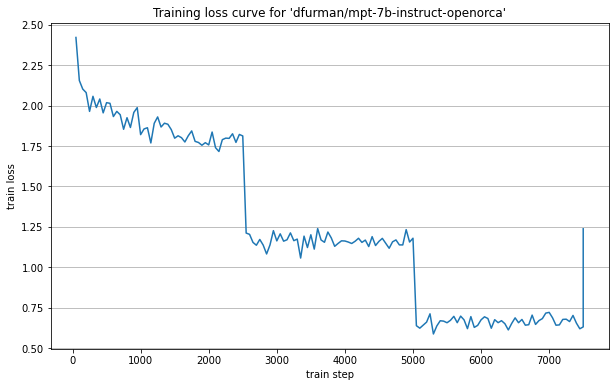

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss)
plt.title("Training loss curve for 'dfurman/mpt-7b-instruct-openorca'")
plt.ylabel("train loss")
plt.xlabel("train step")
plt.grid(which="major", axis="y")
plt.show()

With a supervised finetuned (sft) model in hand, we can test it on some basic prompts and then upload it to the Hugging Face hub either as a public or private model repo, depending on the use case.

In [9]:
# load assets

model_id = "./results/checkpoint-7500"
# model_id = "dfurman/mpt-7b-instruct-reproduced"

# mpt tokenizer load
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

# mpt llm load
config = transformers.AutoConfig.from_pretrained(model_id, trust_remote_code=True)

# custom options
config.attn_config[
    "attn_impl"
] = "triton"  # Optional triton attention for improved latency
config.init_device = "cuda"  # For fast initialization directly on GPU!
# config.max_seq_len = 4096 # (input + output) tokens can now be up to 4096
config.torch_dtype = "bfloat16"  # Set float16 data type

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    config=config,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
)

config

Instantiating an MPTForCausalLM model from /home/ubuntu/.cache/huggingface/modules/transformers_modules/mosaicml/mpt-7b/a78c1fa391580242211a2f516cf9ef10c86713c8/modeling_mpt.py
You are using config.init_device='cuda', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MPTConfig {
  "_name_or_path": "./results/checkpoint-7500",
  "architectures": [
    "MPTForCausalLM"
  ],
  "attn_config": {
    "alibi": true,
    "alibi_bias_max": 8,
    "attn_impl": "triton",
    "attn_pdrop": 0,
    "attn_type": "multihead_attention",
    "attn_uses_sequence_id": false,
    "clip_qkv": null,
    "prefix_lm": false,
    "qk_ln": false,
    "softmax_scale": null
  },
  "auto_map": {
    "AutoConfig": "mosaicml/mpt-7b--configuration_mpt.MPTConfig",
    "AutoModelForCausalLM": "mosaicml/mpt-7b--modeling_mpt.MPTForCausalLM"
  },
  "d_model": 4096,
  "emb_pdrop": 0,
  "embedding_fraction": 1.0,
  "expansion_ratio": 4,
  "init_config": {
    "emb_init_std": null,
    "emb_init_uniform_lim": null,
    "fan_mode": "fan_in",
    "init_div_is_residual": true,
    "init_gain": 0,
    "init_nonlinearity": "relu",
    "init_std": 0.02,
    "name": "kaiming_normal_",
    "verbose": 0
  },
  "init_device": "cuda",
  "learned_pos_emb": true,
  "logit_scale": null,
  "max_seq_len"

## Basic instruction tests

In [10]:
# text generation function


def mpt_generate(
    model: transformers.AutoModelForCausalLM,
    tokenizer: transformers.AutoTokenizer,
    prompt: str,
    max_new_tokens: int = 128,
    temperature: int = 1.0,
) -> str:
    """
    Initialize the pipeline
    Uses Hugging Face GenerationConfig defaults
        https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationConfig
    Args:
        model (transformers.AutoModelForCausalLM): Falcon model for text generation
        tokenizer (transformers.AutoTokenizer): Tokenizer for model
        prompt (str): Prompt for text generation
        max_new_tokens (int, optional): Max new tokens after the prompt to generate. Defaults to 128.
        temperature (float, optional): The value used to modulate the next token probabilities.
            Defaults to 1.0
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        return_token_type_ids=False,
    ).to(
        device
    )  # tokenize inputs, load on device

    # when running Torch modules in lower precision, it is best practice to use the torch.autocast context manager.
    with torch.autocast("cuda", dtype=torch.bfloat16):
        response = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            return_dict_in_generate=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    decoded_output = tokenizer.decode(
        response["sequences"][0],
        skip_special_tokens=True,
    )  # grab output in natural language

    return decoded_output[len(prompt) :]  # remove prompt from output

In [23]:
prompt = "Write me a numbered list of things to do in New York City.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=300,
    temperature=0.92,
)

print(response)

1. Visit the Statue of Liberty: This iconic structure is a must-see in New York City, and you can climb to the top for a breathtaking view.
2. Stroll through Central Park: This park is the perfect place for a leisurely stroll, with beautiful gardens, a boating lake, and plenty of activities for all ages.
3. Take a tour of the Metropolitan Museum: This museum houses a vast collection of art, artifacts, and cultural treasures from around the world, and offers a glimpse into New York City's rich history.
4. Visit the Museum of Contemporary Art: This museum showcases the work of local and international artists, and offers a unique perspective on the city's contemporary art scene.
5. Explore the Brooklyn Museum: This museum, located in Brooklyn, houses a diverse collection of art, artifacts, and cultural objects from around the world, and is just a short subway ride away from Manhattan.
6. Visit the American Museum of Natural History: This museum offers a glimpse into the wonders of nature,

In [33]:
prompt = "Q: Daniel is in need of a haircut. His barber works Mondays, Wednesdays, and Fridays. So, Daniel went in for a haircut on Sunday. Does this make logical sense? Respond in one sentence. A:\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=100,
    temperature=0.92,
)

print(response)

No, this does not make logical sense. 

The statement provided indicates that Daniel's barber only works on Mondays, Wednesdays, and Fridays. Therefore, Daniel went to the barber shop on Sunday, which is not a working day for the barber. As a result, the barber was not available to cut Daniel's hair on Sunday. This scenario does not align with the schedule of the barber, rendering the statement nonsensical. To make a logical sense


In [30]:
prompt = "Write a short email inviting my friends to a dinner party on Friday. Respond succinctly.\n"

response = mpt_generate(
    model,
    tokenizer,
    prompt,
    max_new_tokens=300,
    temperature=0.92,
)

print(response)

Step 1: Identify the purpose of the email
The purpose of this email is to invite my friends to a dinner party on Friday.

Step 2: Choose a suitable subject for the email
I will choose a subject that is catchy and will grab the attention of my friends.

Step 3: Craft the email body
I will create a body for the email that conveys the purpose, provides necessary information, and encourages my friends to attend the dinner party.

Step 4: Attach a file with the invitation
I will attach a file with the invitation, which contains a PDF with the event details, to make it easier for my friends to access and print.

Step 5: Send the email
I will now send the email to my friends, ensuring that it reaches them on time.

Step 6: Follow up
If I don't hear back from my friends within a few days, I will follow up with them to check if they received the email and confirm their attendance.

Email:
Subject: "Invitation: Dinner Party on Friday"

Dear [recipient's name],

I hope this email finds you well. 

## Upload model to Hugging Face
1. Before running the cells below, create a model on your Hugging Face account. It can be a private or public repo and work with the below code.

In [15]:
!pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable


In [18]:
from huggingface_hub import notebook_login

notebook_login()

In [19]:
!git config --global credential.helper store

In [20]:
# push to hub
model_id_load = "dfurman/mpt-7b-instruct-openorca"

# tokenizer
tokenizer.push_to_hub(model_id_load, use_auth_token=True)

CommitInfo(commit_url='https://huggingface.co/dfurman/mpt-7b-instruct-openorca/commit/ce9f6878f0e3f617e6d5a9c183776b975b482602', commit_message='Upload tokenizer', commit_description='', oid='ce9f6878f0e3f617e6d5a9c183776b975b482602', pr_url=None, pr_revision=None, pr_num=None)

In [21]:
# safetensors
model.push_to_hub(model_id_load, use_auth_token=True, safe_serialization=True)
# torch tensors
model.push_to_hub(model_id_load, use_auth_token=True)

model-00002-of-00002.safetensors:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dfurman/mpt-7b-instruct-openorca/commit/8940aa88f8b4bead2fe66a81f7065a4cbd5d9139', commit_message='Upload MPTForCausalLM', commit_description='', oid='8940aa88f8b4bead2fe66a81f7065a4cbd5d9139', pr_url=None, pr_revision=None, pr_num=None)